## Table of Contents

- [Download input data](#download-input-data)
- [Adapter removal and quality trimming](#adapter-removal-and-quality-trimming)
- [Removal of rRNA with Bowtie2](#removal-of-rrna-with-bowtie2)
- [Download and index refgenome](#download-and-index-refgenome)
- [Mapping against the reference genome](#mapping-against-the-reference-genome)
- [Convert SAM to BAM](#convert-sam-to-bam)
- [Detection of circular RNAs from chimeric.out.junction files with circtools](#detection-of-circular-rnas-from-chimericoutjunction-files-with-circtools)
- [Plot Results](#plot-results)

## Download input data 

In [1]:
%%bash
cat > in/reads/jakobi2016_sra_list.txt <<EOF
SRR7881338
SRR7881276
SRR7881275
SRR7881335
SRR7881337
SRR7881336
SRR7881333
SRR7881334
EOF

In [ ]:
%%bash
cat > wonderdump.sh <<'EOF'
#!/bin/bash

# Usage: ./wonderdump.sh --split-files --gzip SRRxxxxxxx

if [[ "$1" == "--split-files" && "$2" == "--gzip" ]]; then
    accession="$3"
    echo "Downloading $accession..."
    fasterq-dump --split-files "$accession" -O .
    echo "Compressing..."
    gzip "${accession}_1.fastq" "${accession}_2.fastq"
    echo "Done: $accession"
else
    echo "Usage: $0 --split-files --gzip <SRA_ID>"
fi
EOF

chmod +x wonderdump.sh

while read sra; do
    ./wonderdump.sh --split-files --gzip "$sra" &
    sleep 60
done < in/reads/jakobi2016_sra_list.txt

In [ ]:
%%bash

input_file="in/reads/jakobi2016_sra_list.txt"

while read -r srr_id; do
  echo "Downloading paired-end reads for $srr_id ..."
  fasterq-dump --split-files "$srr_id"
done < "$input_file"

spots read      : 33,518,478
reads read      : 67,036,956
reads written   : 67,036,956


## Adapter removal and quality trimming

In [22]:
%%bash

READ_DIR="in/reads"
TARGET_DIR="out/trimmed"
LOG_DIR="logs"

mkdir -p "$TARGET_DIR"
mkdir -p "$LOG_DIR"

for READ1 in ${READ_DIR}/SRR*_1.fastq; do
    READ2="${READ1/_1.fastq/_2.fastq}"
    SAMPLE=$(basename "$READ1" | cut -d_ -f1)
    JOB_NAME="flexbar_trim_${SAMPLE}"
    OUTPUT_LOG="${LOG_DIR}/${JOB_NAME}.log"
    TARGET_NAME="${TARGET_DIR}/${SAMPLE}"

    echo "Submitting job for $SAMPLE"

    qsub -N "$JOB_NAME" \
         -cwd \
         -pe smp 4 \
         -o "$OUTPUT_LOG" \
         -j y \
         -V \
         <<EOF
#!/bin/bash
flexbar \
    -r "$READ1" \
    -p "$READ2" \
    -t "$TARGET_NAME" \
    -n 4 \
    -z GZ \
    -m 30 \
    -u 0 \
    -q TAIL \
    -qt 28 \
    -a /home/mkumar4/P/circ_rna/exp_circular/workflow/in/adapter.fa \
    -qf sanger
EOF

done



Submitting job for SRR7881275


Your job 7968192 ("flexbar_trim_SRR7881275") has been submitted
Submitting job for SRR7881276
Your job 7968193 ("flexbar_trim_SRR7881276") has been submitted
Submitting job for SRR7881333
Your job 7968194 ("flexbar_trim_SRR7881333") has been submitted
Submitting job for SRR7881334
Your job 7968195 ("flexbar_trim_SRR7881334") has been submitted
Submitting job for SRR7881335
Your job 7968196 ("flexbar_trim_SRR7881335") has been submitted
Submitting job for SRR7881336
Your job 7968197 ("flexbar_trim_SRR7881336") has been submitted
Submitting job for SRR7881337
Your job 7968198 ("flexbar_trim_SRR7881337") has been submitted
Submitting job for SRR7881338
Your job 7968199 ("flexbar_trim_SRR7881338") has been submitted


## Removal of rRNA with Bowtie2

In [26]:
%%bash

RRNA_INDEX="out/rRNA_cluster/mus-musculus.rRNA"
TRIMMED_DIR="out/trimmed"
TARGET_DIR="out/bowtie2_filtered"
LOG_DIR="logs"

mkdir -p "$TARGET_DIR"
mkdir -p "$LOG_DIR"

for READ1 in ${TRIMMED_DIR}/SRR*_1.fastq.gz; do
    SAMPLE=$(basename "$READ1" | sed 's/_1.fastq.gz//')
    READ2="${TRIMMED_DIR}/${SAMPLE}_2.fastq.gz"

    # Job names and logs for each read
    JOB1="bowtie2_filter_${SAMPLE}_1"
    JOB2="bowtie2_filter_${SAMPLE}_2"
    LOG1="${LOG_DIR}/${JOB1}.log"
    LOG2="${LOG_DIR}/${JOB2}.log"

    echo "Submitting bowtie2 filtering job for ${SAMPLE}_1"
    qsub -N "$JOB1" \
         -cwd \
         -pe smp 20 \
         -o "$LOG1" \
         -j y \
         -V \
         -b y \
         bowtie2 -S /dev/null \
                 -x "$RRNA_INDEX" \
                 -U "$READ1" \
                 --no-unal \
                 --omit-sec-seq \
                 --threads 20 \
                 --mm \
                 --seed 1337 \
                 --time \
                 --un-gz "${TARGET_DIR}/${SAMPLE}_1_filtered.fastq.gz" \
                 2> "${TARGET_DIR}/${SAMPLE}_1_bowtie2.log"

    echo "Submitting bowtie2 filtering job for ${SAMPLE}_2"
    qsub -N "$JOB2" \
         -cwd \
         -pe smp 20 \
         -o "$LOG2" \
         -j y \
         -V \
         -b y \
         bowtie2 -S /dev/null \
                 -x "$RRNA_INDEX" \
                 -U "$READ2" \
                 --no-unal \
                 --omit-sec-seq \
                 --threads 20 \
                 --mm \
                 --seed 1337 \
                 --time \
                 --un-gz "${TARGET_DIR}/${SAMPLE}_2_filtered.fastq.gz" \
                 2> "${TARGET_DIR}/${SAMPLE}_2_bowtie2.log"
done




Submitting bowtie2 filtering job for SRR7881275_1
Your job 7968217 ("bowtie2_filter_SRR7881275_1") has been submitted
Submitting bowtie2 filtering job for SRR7881275_2
Your job 7968218 ("bowtie2_filter_SRR7881275_2") has been submitted
Submitting bowtie2 filtering job for SRR7881276_1
Your job 7968219 ("bowtie2_filter_SRR7881276_1") has been submitted
Submitting bowtie2 filtering job for SRR7881276_2
Your job 7968220 ("bowtie2_filter_SRR7881276_2") has been submitted
Submitting bowtie2 filtering job for SRR7881333_1
Your job 7968221 ("bowtie2_filter_SRR7881333_1") has been submitted
Submitting bowtie2 filtering job for SRR7881333_2
Your job 7968222 ("bowtie2_filter_SRR7881333_2") has been submitted
Submitting bowtie2 filtering job for SRR7881334_1
Your job 7968223 ("bowtie2_filter_SRR7881334_1") has been submitted
Submitting bowtie2 filtering job for SRR7881334_2
Your job 7968224 ("bowtie2_filter_SRR7881334_2") has been submitted
Submitting bowtie2 filtering job for SRR7881335_1
Your j

## Download and index refgenome

In [23]:
%%bash

# Download genome fasta and decompress
wget ftp://ftp.ensembl.org/pub/release-90/fasta/mus_musculus/dna/Mus_musculus.GRCm38.dna.primary_assembly.fa.gz -O out/Mus_musculus.GRCm38.dna.primary_assembly.fa.gz
gzip -d out/Mus_musculus.GRCm38.dna.primary_assembly.fa.gz

# Download GENCODE vM25 annotation and decompress
wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.annotation.gtf.gz -O out/gencode.vM25.annotation.gtf.gz
gzip -d out/gencode.vM25.annotation.gtf.gz

# Remove "chr" prefix from GTF if your FASTA lacks 'chr' in chromosome names
sed 's/^chr//' out/gencode.vM25.annotation.gtf > out/gencode.vM25.annotation.nodot.gtf

# Create STAR index directory
mkdir -p out/star_mm10_index

# Build STAR genome index
STAR --runThreadN 8 \
     --runMode genomeGenerate \
     --genomeDir out/star_mm10_index \
     --genomeFastaFiles out/Mus_musculus.GRCm38.dna.primary_assembly.fa \
     --sjdbGTFfile out/gencode.vM25.annotation.nodot.gtf \
     --sjdbOverhang 100


--2025-06-11 11:27:32--  ftp://ftp.ensembl.org/pub/release-90/fasta/mus_musculus/dna/Mus_musculus.GRCm38.dna.primary_assembly.fa.gz
           => ‘out/Mus_musculus.GRCm38.dna.primary_assembly.fa.gz’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-90/fasta/mus_musculus/dna ... done.
==> SIZE Mus_musculus.GRCm38.dna.primary_assembly.fa.gz ... 805986941
==> PASV ... done.    ==> RETR Mus_musculus.GRCm38.dna.primary_assembly.fa.gz ... done.
Length: 805986941 (769M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  0%  227K 57m50s
    50K .......... .......... .......... .......... ..........  0%  474K 42m44s
   100K .......... .......... .......... .......... ..........  0% 8.39M 29m0s
   150K .......... .......... .......... .......... ...

	/home/mkumar4/miniconda3/envs/manish/bin/STAR-avx2 --runThreadN 8 --runMode genomeGenerate --genomeDir out/star_mm10_index --genomeFastaFiles out/Mus_musculus.GRCm38.dna.primary_assembly.fa --sjdbGTFfile out/gencode.vM25.annotation.nodot.gtf --sjdbOverhang 100
	STAR version: 2.7.11b   compiled: 2025-04-26T21:36:55+0000 :/opt/conda/conda-bld/star_1745703265435/work/source
Jun 11 11:30:09 ..... started STAR run
Jun 11 11:30:09 ... starting to generate Genome files
Jun 11 11:30:47 ..... processing annotations GTF
Jun 11 11:30:59 ... starting to sort Suffix Array. This may take a long time...
Jun 11 11:31:13 ... sorting Suffix Array chunks and saving them to disk...
Jun 11 11:41:56 ... loading chunks from disk, packing SA...
Jun 11 11:43:03 ... finished generating suffix array
Jun 11 11:43:03 ... generating Suffix Array index
Jun 11 11:45:53 ... completed Suffix Array index
Jun 11 11:45:53 ..... inserting junctions into the genome indices
Jun 11 11:48:39 ... writing Genome to disk ...
Jun

## Mapping against the reference genome

In [28]:
%%bash

GENOME_DIR="out/star_mm10_index"
GTF_FILE="out/gencode.vM25.annotation.nodot.gtf"
FILTERED_DIR="out/bowtie2_filtered"
Aligned_DIR="out/STAR_output"
LOG_DIR="logs"

mkdir -p "$Aligned_DIR" "$LOG_DIR"

# Loop over mate1 filtered files
for READ1 in ${FILTERED_DIR}/*_1_filtered.fastq.gz; do
    SAMPLE=$(basename "$READ1" _1_filtered.fastq.gz)
    READ2="${FILTERED_DIR}/${SAMPLE}_2_filtered.fastq.gz"
    
    if [[ ! -f "$READ2" ]]; then
        echo "Missing READ2 for $SAMPLE. Skipping..."
        continue
    fi

    OUT_PREFIX="${Aligned_DIR}/${SAMPLE}_"
    LOGFILE="${LOG_DIR}/STAR_${SAMPLE}.log"

    qsub -N "STAR_${SAMPLE}" \
         -cwd \
         -pe smp 10 \
         -o "$LOGFILE" \
         -j y \
         -V \
         -b y \
         STAR --runThreadN 10 \
              --genomeDir "$GENOME_DIR" \
              --genomeLoad NoSharedMemory \
              --readFilesIn "$READ1" "$READ2" \
              --readFilesCommand zcat \
              --outFileNamePrefix "$OUT_PREFIX" \
              --outReadsUnmapped Fastx \
              --outSAMattributes NH HI AS nM NM MD jM jI XS \
              --outSJfilterOverhangMin 15 15 15 15 \
              --outFilterMultimapNmax 20 \
              --outFilterScoreMin 1 \
              --outFilterMatchNminOverLread 0.7 \
              --outFilterMismatchNmax 999 \
              --outFilterMismatchNoverLmax 0.05 \
              --alignIntronMin 20 \
              --alignIntronMax 1000000 \
              --alignMatesGapMax 1000000 \
              --alignSJoverhangMin 15 \
              --alignSJDBoverhangMin 10 \
              --alignSoftClipAtReferenceEnds No \
              --chimSegmentMin 15 \
              --chimScoreMin 15 \
              --chimScoreSeparation 10 \
              --chimJunctionOverhangMin 15 \
              --sjdbGTFfile "$GTF_FILE" \
              --quantMode GeneCounts \
              --twopassMode Basic \
              --chimOutType Junctions SeparateSAMold
done


Your job 7968272 ("STAR_SRR7881275") has been submitted
Your job 7968273 ("STAR_SRR7881276") has been submitted
Your job 7968274 ("STAR_SRR7881333") has been submitted
Your job 7968275 ("STAR_SRR7881334") has been submitted
Your job 7968276 ("STAR_SRR7881335") has been submitted
Your job 7968277 ("STAR_SRR7881336") has been submitted
Your job 7968278 ("STAR_SRR7881337") has been submitted
Your job 7968279 ("STAR_SRR7881338") has been submitted


## Convert SAM to BAM

In [30]:
%%bash

# Define file paths
SAM="out/STAR_output/SRR7881275_Aligned.out.sam"
BAM="out/STAR_output/SRR7881275_Aligned.out.bam"
SORTED_BAM="out/STAR_output/SRR7881275_Aligned.sorted.bam"

# Step 1: Convert SAM to BAM
echo "Converting SAM to BAM..."
samtools view -bS "$SAM" > "$BAM"

# Step 2: Sort BAM file
echo "Sorting BAM file..."
samtools sort "$BAM" -o "$SORTED_BAM"

# Step 3: Index sorted BAM file
echo "Indexing sorted BAM file..."
samtools index "$SORTED_BAM"

echo "All steps completed for SRR7881275."

Converting SAM to BAM...
Sorting BAM file...


[bam_sort_core] merging from 1 files and 1 in-memory blocks...


Indexing sorted BAM file...
All steps completed for SRR7881275.


## Detection of circular RNAs from chimeric.out.junction files with circtools

In [31]:
%%bash

python3 -m venv circtools # create virtual environment
source circtools/bin/activate # activate virtual environment

python3 -m pip install circtools # install latest circtools version from PyPi

# Submit circtools detect job from mate1
JOB_NAME="circtools_detect_bowtie2_SRR7881275"
OUTPUT_LOG="logs/${JOB_NAME}.log"

mkdir -p logs
mkdir -p out/STAR_output/SRR7881275_circtools

qsub -N "$JOB_NAME" \
     -cwd \
     -pe smp 8 \
     -o "$OUTPUT_LOG" \
     -V \
     -b y \
     -j y \
     circtools detect \
         out/STAR_output/SRR7881275_Chimeric.out.junction \
         -B out/STAR_output/SRR7881275_Aligned.sorted.bam \
         -mt1 out/bowtie2_filtered/SRR7881275_1_filtered.fastq.gz \
         -mt2 out/bowtie2_filtered/SRR7881275_2_filtered.fastq.gz \
         -A in/Mus_musculus.GRCm38.dna.primary_assembly.fa \
         -an in/gencode.vM25.annotation.nodot.gtf \
         -O out/STAR_output/SRR7881275_circtools \
         -R in/mouse_repeats.gtf \
         -T 8 \
         -M \
         -D \
         -fg \
         -G       

# -R: GTF file of known repetitive elements (e.g., RepeatMasker output).

# -an: Ensembl GTF annotation file.

# -A: Reference genome FASTA.

# -Pi: Use paired-end information.

# -F: Filter low-confidence junctions.

# -M: Enable multiple mapping support.

# -Nr 5 6: Require 5 unique reads and 6 total reads to support a junction.  (can't use exact parameters )

# -fg: Output results in a flat file.

# -G: Output circRNA candidates as GTF.

# -D: Debug info.


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Your job 7968283 ("circtools_detect_bowtie2_SRR7881275") has been submitted


In [37]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Plot Results

Rows: 8 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Strand
dbl (4): Chr, Start, End, Sample1_Chimeric.out.junction

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Plots generated for Sample1_circtools


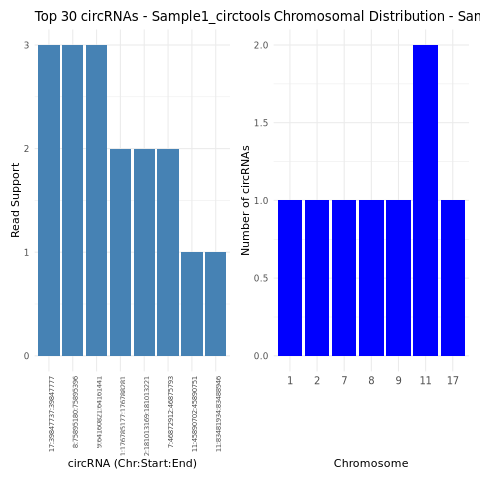

In [38]:
%%R

# Load required libraries
library(ggplot2)
library(dplyr)
library(readr)
library(stringr)

# Set base directory paths
base_dir <- "out"
figure_dir <- file.path(base_dir, "figures")
dir.create(figure_dir, recursive = TRUE, showWarnings = FALSE)

# List all sample circRNA count files
sample_dirs <- list.dirs(base_dir, full.names = TRUE, recursive = FALSE)
circ_files <- file.path(sample_dirs, "CircRNACount")
circ_files <- circ_files[file.exists(circ_files)]

# Iterate over each file
for (circ_file in circ_files) {
  sample_name <- basename(dirname(circ_file))

  # Read file
  circ <- read_tsv(circ_file, col_names = TRUE)

  # Rename columns
  colnames(circ) <- c("Chr", "Start", "End", "Strand", "Count")

  # Normalize chromosome names
  circ$Chr <- gsub("^chr", "", circ$Chr)

  # Factorize chromosome order
  chrom_order <- c(as.character(1:22), "X", "Y", "MT")
  circ$Chr <- factor(circ$Chr, levels = chrom_order)

  # Create unique ID
  circ <- circ %>% mutate(circRNA_ID = paste(Chr, Start, End, sep = ":"))

  # Plot 1: Top 30 circRNAs
  top_circ <- circ %>% arrange(desc(Count)) %>% head(30)

  p1 <- ggplot(top_circ, aes(x = reorder(circRNA_ID, -Count), y = Count)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    labs(title = paste("Top 30 circRNAs -", sample_name),
         x = "circRNA (Chr:Start:End)", y = "Read Support") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, size = 7, hjust = 1))

  ggsave(filename = file.path(figure_dir, paste0(sample_name, "_top30_circRNAs.png")),
         plot = p1, width = 10, height = 6, dpi = 300)

  # Plot 2: Chromosomal Distribution
  p2 <- ggplot(circ, aes(x = Chr)) +
    geom_bar(fill = "blue") +
    labs(title = paste("Chromosomal Distribution -", sample_name),
         x = "Chromosome", y = "Number of circRNAs") +
    theme_minimal() +
    theme(axis.text.x = element_text(size = 10))

  ggsave(filename = file.path(figure_dir, paste0(sample_name, "_chr_distribution.png")),
         plot = p2, width = 8, height = 5, dpi = 300)

  message("Plots generated for ", sample_name)
}

library(patchwork)

# Combine and print side by side
combined_plot <- p1 + p2
print(combined_plot)